# 參數優化

### 參數高原和參數孤島

參數優化中一個重要的原則就是要爭取參數高原而不是參數孤島

參數高原，是指存在著一個較寬的參數範圍，模型在這個參數範圍內都能取得較好的效果，一般會以高原的中心形成近似正態分佈

參數孤島，是指只有在參數值處於某個很小的範圍內時，模型才有較好表現，而當參數偏離該值時，模型的表現便會顯著變差

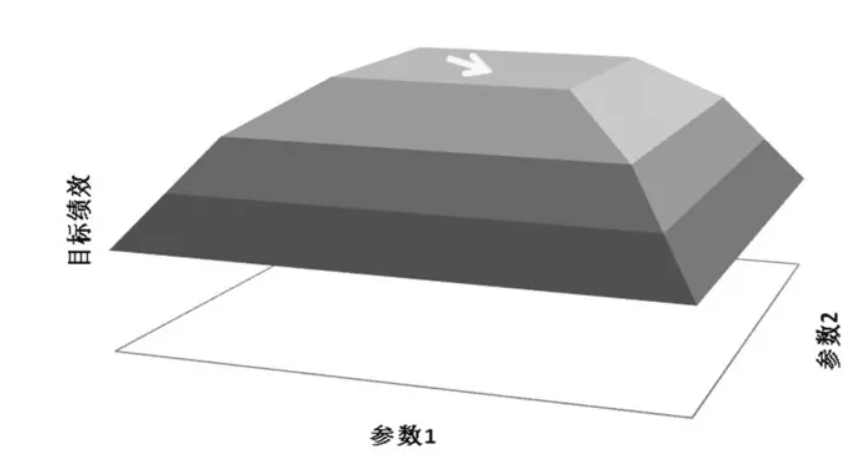

參數高原

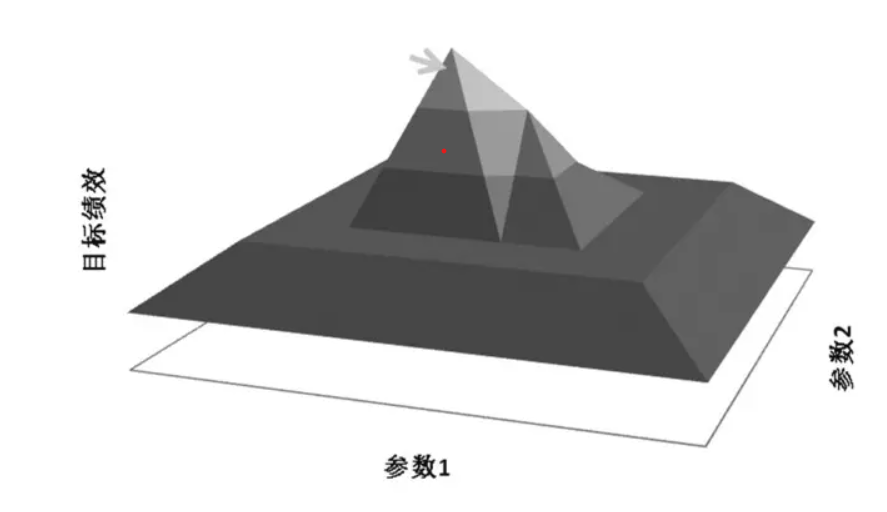

參數孤島

假設某交易模型內有兩個參數，分別為參數1和參數2，當對兩個參數進行遍歷測試後，得到一張三維的績效圖。

好的參數分佈應當是參數高原示意圖，即使當參數的設置有所偏移，模型的獲利績效依然能夠得到保證。這樣的參數因穩定性強，可以使得模型在未來實戰中遇到各類行情時，具有較強的因應能力。

但如果遍歷參數後的績效結果如參數孤島示意圖，當參數發生小的偏移時，模型的獲利績效就發生較大變動，那麼這樣的參數因適應性能差，往往難以應對實際交易中變化多端的市場環境。

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

### 安裝 optuna 的 package

optuna 為一個優化參數的框架

基本概念

使用 study 和 trial 這兩個術語：

．Study：基於目標函數的優化過程。

．Trial：目標函數的單次執行過程。

一個 study 的目的是通過多次 trial（例如 n_trials=100）來找出最佳的超參數值集

而 Optuna 旨在加速和自動化此類 study 的優化過程

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

### 流程

建立一個 data_preprocess 的 class 或 function

In [4]:
import pandas as pd
#import talib
import numpy as np
import vectorbt as vbt 
from vectorbt.portfolio.enums import OrderSide
from numba import njit
import optuna

class preprocess_data():
    def __init__(self, data, channel_timeperiod , channel_multiply, bb_timeperiod, bb_multiply):
        # keltener channel 設 EMA 較好，bollinger bands 設 SMA 較好
        self.channel_timeperiod = channel_timeperiod
        self.channel_multiply = channel_multiply
        self.bb_timeperiod = bb_timeperiod
        self.bb_multiply = bb_multiply
        self.data = data
    
    # 計算 keltner channel
    def keltner_channel(self, high, low, close, type, timeperiod = 20, nbdev = 2):
        if type == "EMA":
            middle_line = talib.EMA(close, timeperiod = timeperiod)
        elif type == "SMA":
            middle_line = talib.SMA(close, timeperiod = timeperiod)
        elif type == "WMA":
            middle_line = talib.WMA(close, timeperiod = timeperiod)         
        atr = talib.ATR(high, low, close, timeperiod = timeperiod)
        # 上通道和下通道tr
        upper_channel = middle_line + nbdev * atr
        lower_channel = middle_line - nbdev * atr 
        return upper_channel, middle_line, lower_channel

    # 計算指標
    def prepare_data(self):
        upper_channel, middle_line, lower_channel = self.keltner_channel(self.data['High'],self. data['Low'], self.data['Close'], "EMA", self.channel_timeperiod, self.channel_multiply)
        upper, middle, lower = talib.BBANDS(self.data['Close'], timeperiod = self.bb_timeperiod, nbdevup=self.bb_multiply, nbdevdn=self.bb_multiply, matype = 0)
        sar = talib.SAR(self.data['High'], self.data['Low'], acceleration=0.02, maximum=0.2)
        five_day_min_low = talib.MIN(self.data['Low'], timeperiod=5) # 五天最低價當作long strategy的停損點
        five_day_max_high = talib.MAX(self.data['High'], timeperiod=5) # 五天最高價當作short strategy的停損點

        # 放入dataframe
        self.data['SAR'] = sar
        self.data['upper_channel'] = upper_channel
        self.data['lower_channel'] = lower_channel
        self.data['upper_bb'] = upper
        self.data['lower_bb'] = lower
        self.data['five_day_min_low'] = five_day_min_low
        self.data['five_day_max_high'] = five_day_max_high

        # 在squeeze中出現close突破upper bb的上漲k棒(long)
        # 在squeeze中出現close跌破lower bb的下跌K棒(short)
        # 最後改成只有squueeze
        self.data['squeeze'] = (self.data['upper_bb'] <= self.data['upper_channel']) & (self.data['lower_bb']  >= self.data['lower_channel'])
        self.data['breakthrough'] = (self.data['Close'] > self.data['Open']) & (self.data['Close'] >= self.data['upper_bb'])
        self.data['breakdown'] = (self.data['Close'] < self.data['Open']) & (self.data['Close'] <= self.data['lower_bb'])
        self.data['target_squeeze_long'] = self.data['squeeze'] 
        self.data['target_squeeze_short'] = self.data['squeeze'] 
        return self.data

ImportError: cannot import name '_broadcast_shape' from 'numpy.lib.stride_tricks' (c:\Users\User\anaconda3\envs\quant\Lib\site-packages\numpy\lib\stride_tricks.py)

把 strategy 寫成一個 function， output 設為優化的目標

In [3]:
# 台股手續費
def custom_fees(order):
    if order.side == OrderSide.Buy:
        return order.size * order.price * 0.001425  
    elif order.side == OrderSide.Sell:
        return order.size * order.price * 0.001425 + order.size * order.price * 0.003  
    return 0

def strategy(data):
    # long strategy
    signals_long = np.zeros(len(data)+1) # 因為是以隔天開盤價做買入
    condition1_long = False
    partition_size_long = 0
    stop_loss_long = 0
    for i in range(3, len(data)):
        if data['target_squeeze_long'][i] and not condition1_long:
            condition1_long = True
        if partition_size_long == 0:
            if condition1_long and not data['squeeze'][i] and data['squeeze'][i-1] and (data['Close'][i] > data['SAR'][i]) and data['breakthrough'][i]:
                signals_long[i+1] = 1
                partition_size_long = 1
                stop_loss_long = data['five_day_min_low'][i]
            elif condition1_long and not data['squeeze'][i] and data['squeeze'][i-2] and (data['Close'][i] > data['SAR'][i]) and data['breakthrough'][i]:
                if data['Close'][i-1] > data['Open'][i-1] :
                    signals_long[i+1] = 1
                    partition_size_long = 1
                    stop_loss_long = data['five_day_min_low'][i]
            elif condition1_long and not data['squeeze'][i] and data['squeeze'][i-3] and (data['Close'][i] > data['SAR'][i]) and data['breakthrough'][i]:
                if (data['Close'][i-1] > data['Open'][i-1]) &  (data['Close'][i-2] > data['Open'][i-2]):
                    signals_long[i+1] = 1
                    partition_size_long = 1
                    stop_loss_long = data['five_day_min_low'][i]
            elif condition1_long and not data['squeeze'][i] and data['squeeze'][i-4] and (data['Close'][i] > data['SAR'][i]) and data['breakthrough'][i]:
                if (data['Close'][i-1] > data['Open'][i-1]) &  (data['Close'][i-2] > data['Open'][i-2]) & (data['Close'][i-3] > data['Open'][i-3]):   
                    signals_long[i+1] = 1
                    partition_size_long = 1
                    stop_loss_long = data['five_day_min_low'][i]


        if partition_size_long == 1:
            # crossover = (data['Close'][i-1] > data['SAR'][i-1]) & (data['Close'][i] < data['SAR'][i])
            if data['squeeze'][i] or (data['Close'][i] <= stop_loss_long): # 停損跟停利
                signals_long[i+1] = -1
                condition1_long = False # condition1重置
                stop_loss_long = 0 # 停損點重置
                partition_size_long = 0 # 平倉
            
    # short strategy
    signals_short = np.zeros(len(data)+1)
    condition1_short = False
    partition_size_short = 0
    stop_loss_short = 0
    for i in range(3, len(data)):
        if data['target_squeeze_short'][i] and not condition1_short:
            condition1_short = True
        if partition_size_short == 0:
            if condition1_short and not data['squeeze'][i] and data['squeeze'][i-1] and (data['Close'][i] < data['SAR'][i]) and data['breakdown'][i]:
                signals_short[i+1] = -1
                partition_size_short = -1
                stop_loss_short = data['five_day_max_high'][i]
            elif condition1_short and not data['squeeze'][i] and data['squeeze'][i-2] and (data['Close'][i] < data['SAR'][i]) and data['breakdown'][i]:
                if data['Close'][i-1] < data['Open'][i-1] :
                    signals_short[i+1] = -1
                    partition_size_short = -1
                    stop_loss_short = data['five_day_max_high'][i]
            elif condition1_short and not data['squeeze'][i] and data['squeeze'][i-3] and (data['Close'][i] < data['SAR'][i]) and data['breakdown'][i]:
                if (data['Close'][i-1] < data['Open'][i-1]) &  (data['Close'][i-2] < data['Open'][i-2]):
                    signals_short[i+1] = -1
                    partition_size_short = -1
                    stop_loss_short = data['five_day_max_high'][i]
            elif condition1_short and not data['squeeze'][i] and data['squeeze'][i-4] and (data['Close'][i] < data['SAR'][i]) and data['breakdown'][i]:
                if (data['Close'][i-1] < data['Open'][i-1]) &  (data['Close'][i-2] < data['Open'][i-2]) & (data['Close'][i-3] < data['Open'][i-3]): 
                    signals_short[i+1] = -1
                    partition_size_short = -1
                    stop_loss_short = data['five_day_max_high'][i]


        if partition_size_short == -1:
            crossunder = (data['Close'][i-1] < data['SAR'][i-1]) & (data['Close'][i] > data['SAR'][i])
            if crossunder or (data['Close'][i] >= stop_loss_short):
                signals_short[i+1] = 1
                condition1_short = False # condition1重置
                stop_loss_short = 0 # 停損點重置
                partition_size_short = 0 # 平倉

    #除錯，將最後一筆signals去掉，index才會相同
    signals_long = signals_long[:-1]
    signals_short = signals_short[:-1]
    
    entries_long = signals_long == 1
    exits_long = signals_long == -1
    entries_short = signals_short == -1
    exits_short = signals_short == 1
    pf_long = vbt.Portfolio.from_signals(data['Open'].values, 
                                        entries_long, 
                                        exits_long,
                                        entries_short,
                                        exits_short,
                                        fees = 0.001425, 
                                        freq='1D', 
                                        direction='both')
    return float(pf_long.sharpe_ratio()),float(pf_long.calmar_ratio()),float(pf_long.total_return())
'''entries_short = signals_short == -1
exits_short = signals_short == 1
pf_short = vbt.Portfolio.from_signals(data['Close'], entries_short, exits_short, direction='shortonly')'''
# print(pf_short.stats().to_string())


"entries_short = signals_short == -1\nexits_short = signals_short == 1\npf_short = vbt.Portfolio.from_signals(data['Close'], entries_short, exits_short, direction='shortonly')"

optuna 做參數 trial

1. 定義超參數搜索空間：定義超參數的搜索範圍。

2. 定義目標函數：編寫一個目標函數，用於評估給定超參數組合的模型性能。

3. 運行 Optuna 優化：使用 Optuna 的 optimize 函數運行優化過程，選擇適當的優化目標。

4. 獲取最佳超參數：通過 Optuna 提供的 API 獲取找到的最佳超參數組合。

In [6]:
import optuna
# 讀取data
data = pd.read_csv("2330 2022-2023.csv")
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

def objective(trial):
    portfolio_params = {
        "channel_timeperiod": trial.suggest_int("channel_timeperiod", 18, 30),
        "channel_multiply": trial.suggest_float("channel_multiply", 1.5, 1.6),
        # "channel_middleline": trial.suggest_categorical( "channel_middlelines", choices=["SMA", "EMA", "WMA"]),
        "bb_timeperiod": trial.suggest_int("bb_timeperiod", 18, 20 ),
        "bb_multiply": trial.suggest_float("bb_multiply", 2, 2.3),
        # "bb_middleline": trial.suggest_categorical("bb_middlelines", choices=[0, 1, 2]),
    }
    data_generate = preprocess_data(data,**portfolio_params)
    preprocessed_data = data_generate.prepare_data()
    sharpe_ratio , calmar_ration, total_return = strategy(preprocessed_data)
    return sharpe_ratio, total_return

study = optuna.create_study(directions = ["maximize","maximize"])
study.optimize(objective, n_trials= 3000)  # number of iterations
study.best_trials


[I 2024-01-17 19:56:36,242] A new study created in memory with name: no-name-53436581-f129-47c0-866a-359b8716d0ef


C:\Users\Admin\AppData\Local\Temp\ipykernel_2564\3426583356.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['target_squeeze_long'][i] and not condition1_long:
C:\Users\Admin\AppData\Local\Temp\ipykernel_2564\3426583356.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition1_long and not data['squeeze'][i] and data['squeeze'][i-1] and (data['Close'][i] > data['SAR'][i]) and data['breakthrough'][i]:
C:\Users\Admin\AppData\Local\Temp\ipykernel_2564\3426583356.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated

[FrozenTrial(number=13, state=TrialState.COMPLETE, values=[-0.13663646717751848, -0.013986736352145073], datetime_start=datetime.datetime(2024, 1, 17, 19, 56, 37, 615944), datetime_complete=datetime.datetime(2024, 1, 17, 19, 56, 37, 762420), params={'channel_timeperiod': 18, 'channel_multiply': 1.5970479858241025, 'bb_timeperiod': 18, 'bb_multiply': 2.206376595556934}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'channel_timeperiod': IntDistribution(high=30, log=False, low=18, step=1), 'channel_multiply': FloatDistribution(high=1.6, log=False, low=1.5, step=None), 'bb_timeperiod': IntDistribution(high=20, log=False, low=18, step=1), 'bb_multiply': FloatDistribution(high=2.3, log=False, low=2.0, step=None)}, trial_id=13, value=None),
 FrozenTrial(number=332, state=TrialState.COMPLETE, values=[-0.13663646717751848, -0.013986736352145073], datetime_start=datetime.datetime(2024, 1, 17, 19, 57, 6, 811841), datetime_complete=datetime.datetime(2

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

### Hiplot 繪圖找參數高原


HiPlot 是一個用於可視化和分析高維數據的 Python 庫。提供了直觀的交互式界面，可以幫助快速理解數據特徵和分佈

In [7]:
import hiplot as hip

# 獲取試驗數據作為 pandas DataFrame
df = study.trials_dataframe()
# 將 DataFrame 導出到 CSV 文件
df.rename(columns={"values_0": "sharpe_ratio","values_1":"total_return"}, inplace=True)
df.to_csv("2330_2022-2023_trials.csv", index=False)
df = df.drop(columns= ['datetime_start','datetime_complete','duration','state','number','system_attrs_nsga2:generation'])
hiplot_experiment = hip.Experiment.from_dataframe(df)
hiplot_experiment.display()

<IPython.core.display.Javascript object>

''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

### 樣本內外測試(In-sample Out-sample test)

https://medium.com/@eric07310115/%E4%BD%BF%E7%94%A8-bollinger-bands-keltner-squeeze-%E9%85%8D%E5%90%88-sar-%E6%8C%87%E6%A8%99%E7%9A%84%E9%A0%86%E5%8B%A2%E4%BA%A4%E6%98%93%E7%AD%96%E7%95%A5-4c6ffab5b64c